# Calibrating the Direct CNOT gate

In [1]:
import logging
from copy import deepcopy
import warnings
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from qiskit.circuit import Gate
from qiskit import transpile
from qiskit.transpiler import InstructionProperties
from qiskit_utilities import (
    save_job_data,
    setup_logger,
    retrieve_expdata,
    get_cr_schedule,
    iy_drag_calibration,
    get_default_cr_params,
    read_calibration_data,
    create_direct_cnot_schedule,
    rough_rz0_correction_calibration,
    fine_rz0_correction_calibration,
    initilize_qiskit_dynamics_backend
)
session = None  # qiskit runtime session

/Users/bli/.local/lib/python3.11/site-packages/qiskit_dynamics/dispatch/backends/jax.py:34: UserWarning: The functionality in the perturbation module of Qiskit Dynamics requires a JAX version <= 0.4.6, due to a bug in JAX versions > 0.4.6. For versions 0.4.4, 0.4.5, and 0.4.6, using the perturbation module functionality requires setting os.environ['JAX_JIT_PJIT_API_MERGE'] = '0' before importing JAX or Dynamics.
  warnings.warn(


In [2]:
# Setup a logging system.
setup_logger(filename=None, level=logging.INFO, stdout=True)
logger = logging.getLogger("qiskit_utilities")

2024-04-25 18:35:04,551, MainThread 
INFO Logger initialized successfully.


In [3]:
# Create a qiskit-dynamics backend with two Transmon, see fake_backend.py for detail.
# fidelity
f0 = 5.188339840468758e9
f1 = 5.079647268847252e9
# anharmonicity
a0 = -0.341931669003125e9
a1 = -0.343248404293835e9
backend = initilize_qiskit_dynamics_backend(f0, f1, a0, a1, J=0.0030e9)

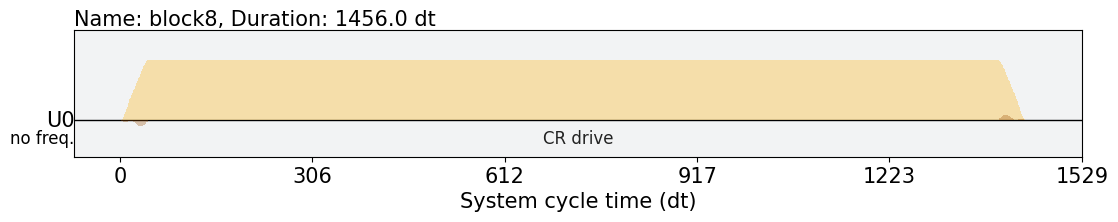

In [4]:
# Operating qubits
QUBIT_C, QUBIT_T = (0, 1)
# Multiple the amplitude by a ratio factor.
ratio = 1
# Compute the sampling time steps for the CR tomography experiments
if backend.name == 'DynamicsBackend':
    amp = 2 * pi * 0.06
    cr_times = np.arange(16*16, 1440*3, 32*4, dtype=int)
    duration = 720*2 # Used for plotting only, not tomography.
else:
    amp = get_default_cr_params(backend, QUBIT_C, QUBIT_T)[0]
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4 / ratio
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)

# Custom shape
gate_name = "CR-recursive-tr10-direct"
params = {
    "order": "3",  # order m for the initial pulse shape
    "t_r": 10,
    "drag_type" : "exact",  # Givens rotation, use "sw" for perturbation
    "duration": duration,  # only for plotting
    "amp": amp,
    "angle": 0.0,
    ## If real device, use the following
    # "Delta": (backend.properties().frequency(QUBIT_C) - backend.properties().frequency(QUBIT_T)) * 1.0e-9 * 2 * pi,
    # "a1": 2 * pi * backend.properties().qubit_property(QUBIT_C)["anharmonicity"][0] * 1.0e-9,
    ## If Dynamicsbackend, use this
    "Delta": 2 * pi * (f0 - f1) * 1.0e-9,
    "a1": 2 * pi * a0 * 1.0e-9,
    "drag_scale": [1., 1., 1.],
}
cr_params = params.copy()
ix_params = params.copy()
ix_params["amp"] = 0.0
ix_params["order"] = "2"
ix_params["drag_type"] = "01"  # single-derivative DRAG

initial_calibration_data = {
    "cr_params": cr_params,
    "ix_params": ix_params,
    "frequency_offset": 0.,
}

get_cr_schedule((QUBIT_C, QUBIT_T), backend, cr_params=cr_params, ix_params=ix_params).draw()

2024-04-25 18:36:11,015, MainThread 
INFO Target IX / ZX ratio: 0.0
2024-04-25 18:36:11,016, MainThread 
INFO 

CR calibration round 1: 
2024-04-25 18:38:54,398, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 18:40:44,679, MainThread 
INFO CR tomography: 615b98a9-ff08-4cc0-a0e8-de4998b579ff
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 1440, 'amp': 0.37699111843077515, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 1440, 'amp': 0.0, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
x_gate_ix_params: None
frequency_offset: 0.0
dt: 2.2222222222222221e-

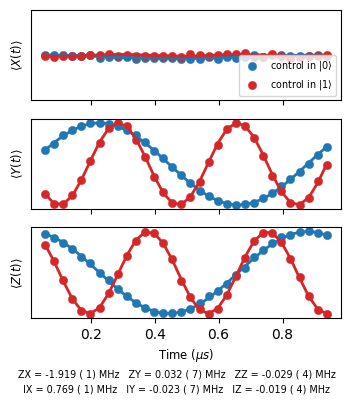

2024-04-25 18:40:45,700, MainThread 
INFO Tomography results:
{'IX': 0.7685595911937502, 'IY': -0.023024799149462347, 'IZ': -0.018557992782697375, 'ZX': -1.9188700795530373, 'ZY': 0.03213579366674327, 'ZZ': -0.02889394110170082}

2024-04-25 18:40:45,701, MainThread 
INFO Frequency offset is updated to -18557.992782697376 Hz
2024-04-25 18:40:45,702, MainThread 
INFO Remaining dominant error: IX: 0.7685595911937502 MHz

2024-04-25 18:40:45,702, MainThread 
INFO Omega[GHz]/amp: 0.15915494309189535
2024-04-25 18:40:45,703, MainThread 
INFO Probe amp shift [MHz]: -0.7685595911937502 MHz
2024-04-25 18:40:45,704, MainThread 
INFO Probe amp shift (amp): -0.00482900233108052
2024-04-25 18:44:41,773, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 18:46:22,191, MainThread 
INFO CR tomography: 105befdf-80a7-40f3-87de-7a8b6dd07b71
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2

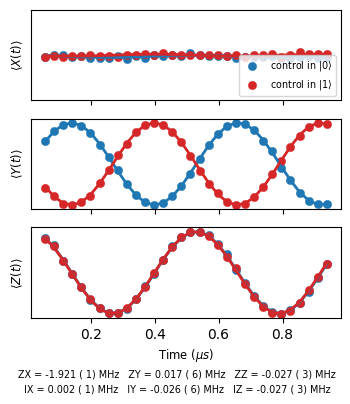

2024-04-25 18:46:23,165, MainThread 
INFO {'IX': 0.0017709925905259047, 'IY': -0.02575389945017662, 'IZ': -0.027095415437555986, 'ZX': -1.9206799944199116, 'ZY': 0.017311084043371713, 'ZZ': -0.027159365857521406}
2024-04-25 18:46:23,166, MainThread 
INFO Estimated drive scale: 
(0.1587882022064898+0.0005651478532427251j)
(0.15878920792064272+0j)
0.003559114966279289
2024-04-25 18:46:23,168, MainThread 
INFO CR calibration data saved.
2024-04-25 18:46:23,168, MainThread 
INFO 

CR calibration round 2: 
2024-04-25 18:50:26,491, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 18:52:05,152, MainThread 
INFO CR tomography: d21b998f-ea75-49e0-a057-1ac52d1b1845
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 1440, 'amp': 0.3769

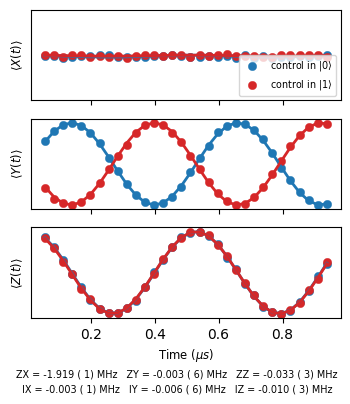

2024-04-25 18:52:06,120, MainThread 
INFO Tomography results:
{'IX': -0.0033471872799049527, 'IY': -0.006055003769001622, 'IZ': -0.010095037896732391, 'ZX': -1.9193057270046254, 'ZY': -0.0026299675268784055, 'ZZ': -0.033122749029949654}

2024-04-25 18:52:06,121, MainThread 
INFO Remaining dominant error: IY: 0.006055003769001622 MHz

2024-04-25 18:52:06,121, MainThread 
INFO Successfully calibrated.
2024-04-25 18:52:06,122, MainThread 
INFO CR calibration data saved.


In [5]:
from qiskit_utilities import iterative_cr_pulse_calibration
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    initial_calibration_data=initial_calibration_data,
    cr_times=cr_times,
    session=session,
    gate_name=gate_name,
    verbose=True,
    restart=True,
    max_repeat=3,
    rerun_last_calibration=True,
    shots=2048,
    mode="CR",
    )

2024-04-25 18:52:06,135, MainThread 
INFO 
Calibrating the IY-DRAG pulse for (0, 1)-CR-recursive-tr10-direct.
2024-04-25 18:56:14,463, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 18:57:53,043, MainThread 
INFO CR tomography: 0bca81b6-3b2a-478c-bea0-35566bd80558
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 1440, 'amp': 0.37699111843077515, 'angle': -0.016745682855649233, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 1440, 'amp': -0.004839578115796782, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 0.0}
x_gate_ix_params: None
frequency_offset: -18557

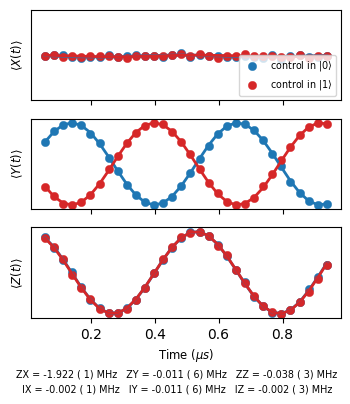

2024-04-25 19:02:11,114, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 19:03:50,043, MainThread 
INFO CR tomography: 75d9f1fc-7583-43a8-be5f-6c2979af2ad2
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 1440, 'amp': 0.37699111843077515, 'angle': -0.016745682855649233, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 1440, 'amp': -0.004839578115796782, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': -10.0}
x_gate_ix_params: None
frequency_offset: -18557.992782697376
dt: 2.2222222222222221e-10

2024-04-25 19:03:50,442, MainThread 
INFO Job saved to data/75d9f1

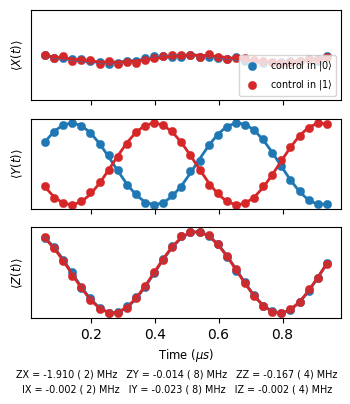

2024-04-25 19:08:07,162, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 19:09:47,851, MainThread 
INFO CR tomography: fc37f7e2-7b35-4929-b1fb-186ca54e83da
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 1024
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 1440, 'amp': 0.37699111843077515, 'angle': -0.016745682855649233, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 1440, 'amp': -0.004839578115796782, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 10.0}
x_gate_ix_params: None
frequency_offset: -18557.992782697376
dt: 2.2222222222222221e-10

2024-04-25 19:09:48,254, MainThread 
INFO Job saved to data/fc37f7e

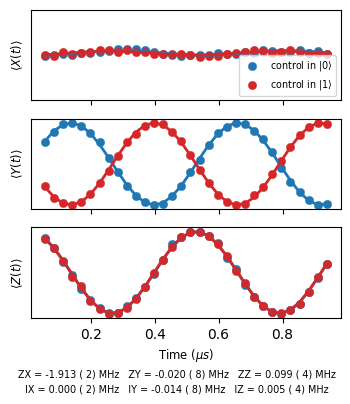

2024-04-25 19:09:48,794, MainThread 
INFO ZZ sampling measurements complete : [-0.03770444135561666, -0.16650823009696833, 0.09910856812975592].

2024-04-25 19:09:48,796, MainThread 
INFO Calibrated IY beta: 2.63798836138656



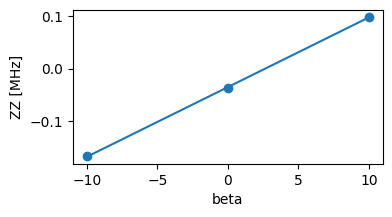

2024-04-25 19:14:04,735, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 19:15:46,531, MainThread 
INFO CR tomography: 4af2ecc6-dca2-4efe-aef4-b588043ea430
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224]
shots: 2048
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 1440, 'amp': 0.37699111843077515, 'angle': -0.016745682855649233, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}
ix_params: {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 1440, 'amp': -0.004839578115796782, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 2.63798836138656}
x_gate_ix_params: None
frequency_offset: -18557.992782697376
dt: 2.2222222222222221e-10

2024-04-25 19:15:47,031, MainThread 
INFO Job saved to 

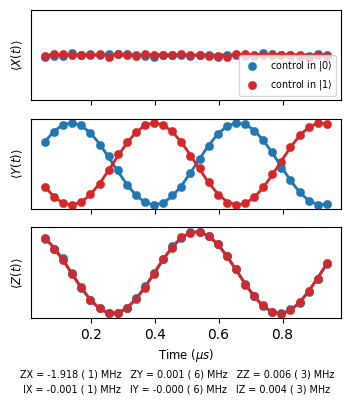

2024-04-25 19:15:47,695, MainThread 
INFO Updated coupling strength: {'IX': -0.0010161313621022757, 'IY': -0.00024359277465580746, 'IZ': 0.004222603254730437, 'ZX': -1.9182199643295368, 'ZY': 0.0008263142179106472, 'ZZ': 0.005945417259774541}
2024-04-25 19:15:47,696, MainThread 
INFO IY-DRAG calibration complete, new calibration data saved.


In [6]:
iy_drag_calibration((QUBIT_C, QUBIT_T), backend, gate_name, cr_times, session, verbose=True, delta_beta=10.)

## Calibrating the target drive for a direct CNOT

On top of the calibration above, we add a pulse on resonant with the target qubit such that $\nu_{ZX}=\nu_{IX}$. Calibration data is saved under the tag "x_gate_ix_params", This ensures that the target qubit only rotates if the control is in state $|1\rangle$.

Therefore, we aim at setting the target qubit tomography to $\nu_{X}=\nu_{IX}+\nu_{ZX}==2\nu_{ZX}$.

2024-04-25 19:15:47,711, MainThread 
WARNING Last calibration job for CR-recursive-tr10-direct not found or not used. Starting from scratch.
2024-04-25 19:15:47,712, MainThread 
INFO Loading existing calibration data...
2024-04-25 19:15:47,713, MainThread 
INFO Target IX / ZX ratio: -2
2024-04-25 19:15:47,714, MainThread 
INFO 

CR calibration round 1: 
2024-04-25 19:22:21,085, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 19:23:59,457, MainThread 
INFO CR tomography: 612953a0-fdf1-4ff4-b0a4-a8a8ee711233
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224 4352 4480 4608 4736 4864 4992 5120 5248 5376 5504
 5632]
shots: 8096
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 1440, 'amp': 0.37699111843077515, 'angle': -0.016745682855649233, 'Delta': 0.6829355690118097, 'a1': -2.1484200387

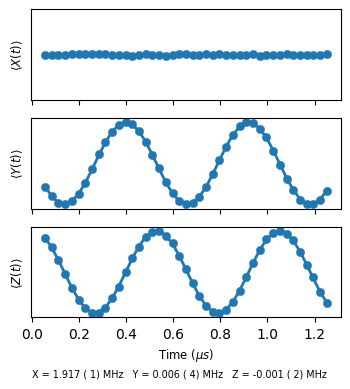

2024-04-25 19:24:00,295, MainThread 
INFO Tomography results:
{'IX': 1.9174340350993015, 'IY': 0.006075017216209681, 'IZ': -0.0009065353537895696}

2024-04-25 19:24:00,295, MainThread 
INFO Remaining dominant error: IX: 1.919005893559772 MHz

2024-04-25 19:24:00,296, MainThread 
INFO Omega[GHz]/amp: 0.15878920792064272
2024-04-25 19:24:00,296, MainThread 
INFO Probe amp shift [MHz]: 1.919005893559772 MHz
2024-04-25 19:24:00,297, MainThread 
INFO Probe amp shift (amp): 0.012085241300018475
2024-04-25 19:30:26,535, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 19:31:57,889, MainThread 
INFO CR tomography: 376d9240-e638-4a2a-af31-8b432bc01255
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224 4352 4480 4608 4736 4864 4992 5120 5248 5376 5504
 5632]
shots: 8096
cr_params: {'order': '3', 't_r': 10, 'drag_type

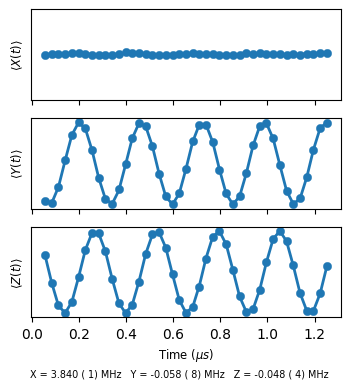

2024-04-25 19:31:58,780, MainThread 
INFO {'IX': 3.8399439962992292, 'IY': -0.05811527262881774, 'IZ': -0.04769776624099067}
2024-04-25 19:31:58,781, MainThread 
INFO Estimated drive scale: 
(0.15907915394266797-0.005311461165854363j)
(0.15916780088583066+0j)
-0.03337639529718994
2024-04-25 19:31:58,782, MainThread 
INFO CR calibration data saved.
2024-04-25 19:31:58,783, MainThread 
INFO 

CR calibration round 2: 
2024-04-25 19:38:25,381, MainThread 
INFO Tomography circuits have been generated.
2024-04-25 19:39:56,380, MainThread 
INFO CR tomography: 5515164b-38d4-4e46-909d-77deaf41d3cb
backend: DynamicsBackend
qubits: (0, 1)
cr_times: [ 256  384  512  640  768  896 1024 1152 1280 1408 1536 1664 1792 1920
 2048 2176 2304 2432 2560 2688 2816 2944 3072 3200 3328 3456 3584 3712
 3840 3968 4096 4224 4352 4480 4608 4736 4864 4992 5120 5248 5376 5504
 5632]
shots: 8096
cr_params: {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 1440, 'amp': 0.37699111843077515, 'angle': -0.01674

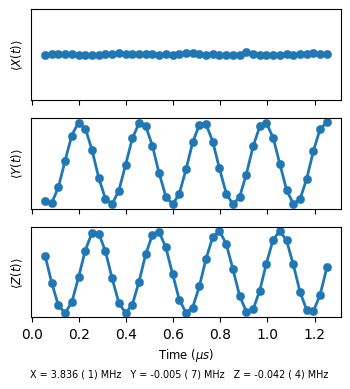

2024-04-25 19:39:57,309, MainThread 
INFO Tomography results:
{'IX': 3.8358024283642083, 'IY': -0.00456871116873504, 'IZ': -0.042408762462961574}

2024-04-25 19:39:57,310, MainThread 
INFO Remaining dominant error: IY: 0.00456871116873504 MHz

2024-04-25 19:39:57,310, MainThread 
INFO Successfully calibrated.
2024-04-25 19:39:57,311, MainThread 
INFO CR calibration data saved.


In [7]:
# Reduce cr_times by a half
if backend.name == 'DynamicsBackend':
    cr_times = np.arange(16*16, 1440*4, 32*4, dtype=int)
else:
    duration = backend.defaults().instruction_schedule_map.get("cx", (QUBIT_C, QUBIT_T)).duration/16 * 4 / ratio / 2
    cr_times = 16 * np.arange(16, duration + 16, duration//30, dtype=int)
from qiskit_utilities import iterative_cr_pulse_calibration
iterative_cr_pulse_calibration(
    (QUBIT_C, QUBIT_T),
    backend,
    cr_times,
    session,
    gate_name=gate_name,
    initial_calibration_data=None,
    verbose=True,
    threshold_MHz=0.015,
    restart=True,
    rerun_last_calibration=False,
    max_repeat=3,
    shots=8096,
    mode="IX-pi"
    )

## Calibrating the ZI phase

So far we only created a CR operation, the drive on the control qubit will accumulate a phase. Since the phase commute with the CR operation, it can be cancelled by adding a RZ rotation on the control at the end of the pulse.

2024-04-25 19:39:57,327, MainThread 
INFO Rough calibration of the RZ0 phase correction.
2024-04-25 19:42:53,955, MainThread 
INFO ZI calibration ID: f1d97fb7-c8af-453c-82ff-d3d690048884
name: rz0 calibration
backend: DynamicsBackend
qubits: (0, 1)
phase_list: [-3.14159265 -3.01336438 -2.88513611 -2.75690784 -2.62867957 -2.5004513
 -2.37222302 -2.24399475 -2.11576648 -1.98753821 -1.85930994 -1.73108167
 -1.60285339 -1.47462512 -1.34639685 -1.21816858 -1.08994031 -0.96171204
 -0.83348377 -0.70525549 -0.57702722 -0.44879895 -0.32057068 -0.19234241
 -0.06411414  0.06411414  0.19234241  0.32057068  0.44879895  0.57702722
  0.70525549  0.83348377  0.96171204  1.08994031  1.21816858  1.34639685
  1.47462512  1.60285339  1.73108167  1.85930994  1.98753821  2.11576648
  2.24399475  2.37222302  2.5004513   2.62867957  2.75690784  2.88513611
  3.01336438  3.14159265]
shots: 1024

2024-04-25 19:42:54,351, MainThread 
INFO Job saved to data/f1d97fb7-c8af-453c-82ff-d3d690048884

2024-04-25 19:42:54

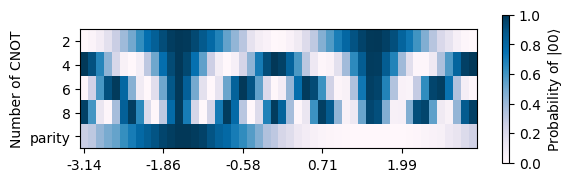

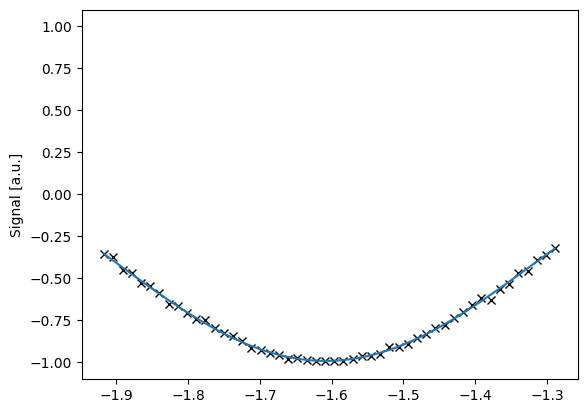

In [8]:
rough_rz0_correction_calibration(backend, (QUBIT_C, QUBIT_T), gate_name, session)
fine_rz0_correction_calibration(backend, (QUBIT_C, QUBIT_T), gate_name, session, num_repeat_cnot=6)

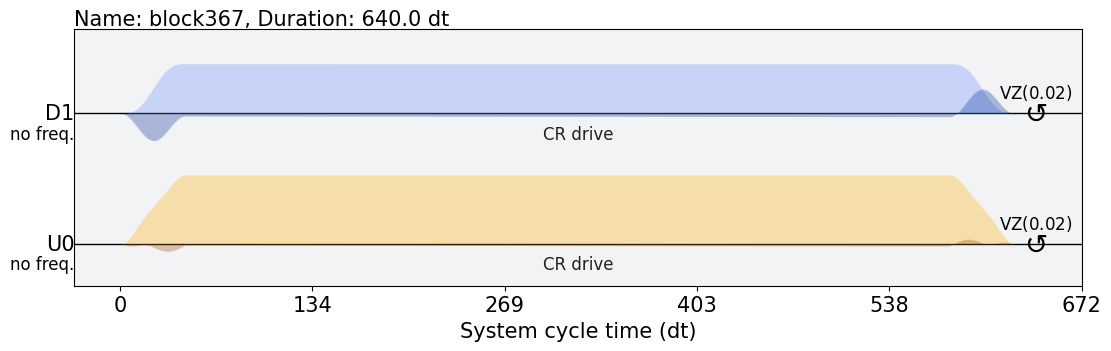

In [9]:
from qiskit_experiments.library import ProcessTomography
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))
custom_cnot_sched = create_direct_cnot_schedule(backend, (QUBIT_C, QUBIT_T), calibration_data, reverse_direction=False)
# Show the custom CNOT schedule.
custom_cnot_sched.draw()

In [10]:
custom_cnot = Gate("custom_cnot", 2, [])
backend_tmp = deepcopy(backend)
backend_tmp.target.add_instruction(
    custom_cnot,
    {(QUBIT_C, QUBIT_T): InstructionProperties(calibration=custom_cnot_sched)},
    name="custom_cnot",
)
qptexp = ProcessTomography(custom_cnot, physical_qubits=[QUBIT_C, QUBIT_T])

try:
    basis_gates = backend.configuration().basis_gates
except AttributeError:
    basis_gates = ["measure", "sx", "x", "rz"]
transpiled_circ_list = transpile(
    qptexp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates = basis_gates + ["custom_cnot"],
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )

shots=8096
if session is not None:
    qpt_job = session.run(
        "circuit-runner",
        inputs={
            "circuits": transpiled_circ_list,
            "skip_transpilation": True,
            "shots": shots,
        },
    )
else:
    qpt_job = backend.run(transpiled_circ_list, shots=shots)

parameters = {
    "backend": backend.name,
    "qubits": (QUBIT_C, QUBIT_T),
    "shots": shots,
    }
logger.info(
    "Quantum process tomography job: "+
    str(qpt_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )

save_job_data(qpt_job, backend=backend, parameters=parameters)

2024-04-25 19:44:19,730, MainThread 
INFO Quantum process tomography job: fb70f4f7-f347-4dce-b494-e0c2c2bd7d87
backend: DynamicsBackend
qubits: (0, 1)
shots: 8096

2024-04-25 19:44:20,177, MainThread 
INFO Job saved to data/fb70f4f7-f347-4dce-b494-e0c2c2bd7d87



(<Figure size 800x600 with 2 Axes>,
 <Axes3D: title={'center': 'Process Matrix'}>)

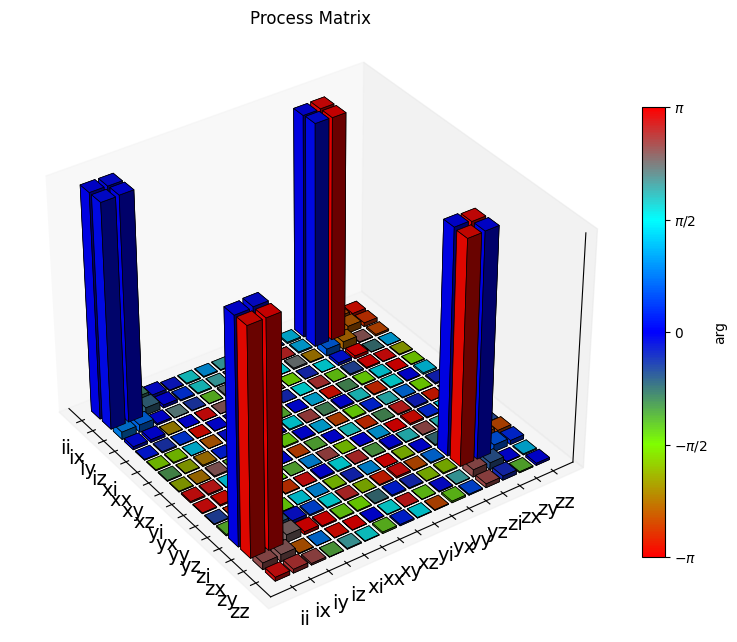

In [11]:
import qutip
qptdata = retrieve_expdata(qpt_job, backend=backend, exp=qptexp)

state_result = qptdata.analysis_results("state")
choi_matrix = state_result.value.data
choi_qobj = qutip.Qobj(
    choi_matrix, dims=[[[2, 2], [2, 2]], [[2, 2], [2, 2]]], superrep="choi"
)
choi_qobj = choi_qobj.permute([[1, 0], [3, 2]])  # Permute the two qubit
qutip.to_super(choi_qobj)
op_basis = [[qutip.qeye(2), qutip.sigmax(), qutip.sigmay(), qutip.sigmaz()]] * 2
chi = qutip.qpt(qutip.to_super(choi_qobj), op_basis)
qutip.qpt_plot_combined(
    chi, lbls_list=[["i", "x", "y", "z"]] * 2, title="Process Matrix"
)

## Randomized benchmakring

Since randomized benchmarking is very slow with the pulse simulator, we only perform RB up to 60 Clifford. The following cell takes approximately 1.5 hours.

In [12]:
from qiskit.circuit.library import CXGate
from qiskit_experiments.library import InterleavedRB


mode = "with_correction"
direct = True
if mode not in ("with_correction", "without_correction", "default"):
    raise ValueError("Unknown mode.")
backend_tmp = deepcopy(backend)
rb_gate = CXGate()
calibration_data = read_calibration_data(backend, gate_name, (QUBIT_C, QUBIT_T))
if mode != "default":
    modified_calibration_data = deepcopy(calibration_data)
    if mode == "without_correction":
        modified_calibration_data["ix_params"]["beta"] = 0.
        modified_calibration_data["frequency_offset"] = 0.
        modified_calibration_data["x_gate_frequency_offset"] = 0.
    # Direct gate
    custom_cnot_sched = create_direct_cnot_schedule(backend, (QUBIT_C, QUBIT_T), modified_calibration_data, with_separate_x=False)
    backend_tmp.target["cx"][(QUBIT_C, QUBIT_T)] = InstructionProperties(calibration=custom_cnot_sched)

    custom_cnot_sched = create_direct_cnot_schedule(backend, (QUBIT_C, QUBIT_T), modified_calibration_data, with_separate_x=False, reverse_direction=True)
    backend_tmp.target["cx"][(QUBIT_T, QUBIT_C)] = InstructionProperties(calibration=custom_cnot_sched)


seed = np.random.randint(2**16)
num_sampling = 30
lengths = [1, 10, 20, 30, 40, 50, 60]

irb_exp = InterleavedRB(
    interleaved_element=rb_gate, physical_qubits=[QUBIT_C, QUBIT_T], lengths=lengths, num_samples=num_sampling, backend=backend_tmp, seed=seed)

transpiled_circ_list = transpile(
    # One must use _transpiled_circuits because it will include the calibration
    irb_exp._transpiled_circuits(),
    backend=backend_tmp,
    basis_gates= ["x", "sx", "rz", "cx"], #+ ["custom_cnot"],
    # initial_layout = [QUBIT_C, QUBIT_T],  # Map the circuit to the target qubits
    optimization_level= 1,  # Turn off optimization to keep the custom pulse
    )
shots = 4096
rb_job = backend_tmp.run(
    transpiled_circ_list,
    shots=shots,
    )
parameters = {
    "backend": backend.name,
    "mode": mode,
    "with_separate_x": False,
    "direct": direct,
    "qubits": [QUBIT_C, QUBIT_T],
    "gate": rb_gate.name,
    "shots": shots,
    "lengths": lengths,
    "num_sampling": num_sampling,
    "seed": seed,
    "calibration_data": calibration_data,
    }
logger.info(
    "Randomized benchmarking job: "+
    str(rb_job.job_id()) + "\n"
    + "\n".join([f"{key}: {val}" for key, val in parameters.items()])
    + "\n"
    )
save_job_data(rb_job, backend=backend, parameters=parameters)


2024-04-25 21:06:55,031, MainThread 
INFO Randomized benchmarking job: a9a95f63-6c84-45d2-b1ce-59c178433009
backend: DynamicsBackend
mode: with_correction
with_separate_x: False
direct: True
qubits: [0, 1]
gate: cx
shots: 4096
lengths: [1, 10, 20, 30, 40, 50, 60]
num_sampling: 30
seed: 9946
calibration_data: {'cr_params': {'order': '3', 't_r': 10, 'drag_type': 'exact', 'duration': 1440, 'amp': 0.37699111843077515, 'angle': -0.016745682855649233, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0]}, 'ix_params': {'order': '2', 't_r': 10, 'drag_type': '01', 'duration': 1440, 'amp': -0.004839578115796782, 'angle': 0.0, 'Delta': 0.6829355690118097, 'a1': -2.148420038739829, 'drag_scale': [1.0, 1.0, 1.0], 'beta': 2.63798836138656}, 'frequency_offset': -18557.992782697376, 'calibration_job_id': '4af2ecc6-dca2-4efe-aef4-b588043ea430', 'coeffs': {'IX': -0.0010161313621022757, 'IY': -0.00024359277465580746, 'IZ': 0.004222603254730437, 'ZX': -1.9182199643295368, 

In [13]:
from qiskit_utilities import load_job_data
parameters = load_job_data(rb_job)["parameters"]
exp_rb = InterleavedRB(
    interleaved_element=CXGate(),
    physical_qubits=[QUBIT_C, QUBIT_T],
    lengths=parameters["lengths"],
    num_samples=parameters["num_sampling"],
    backend=backend,
    seed=parameters["seed"])
exp_data = retrieve_expdata(rb_job, backend, exp=exp_rb)

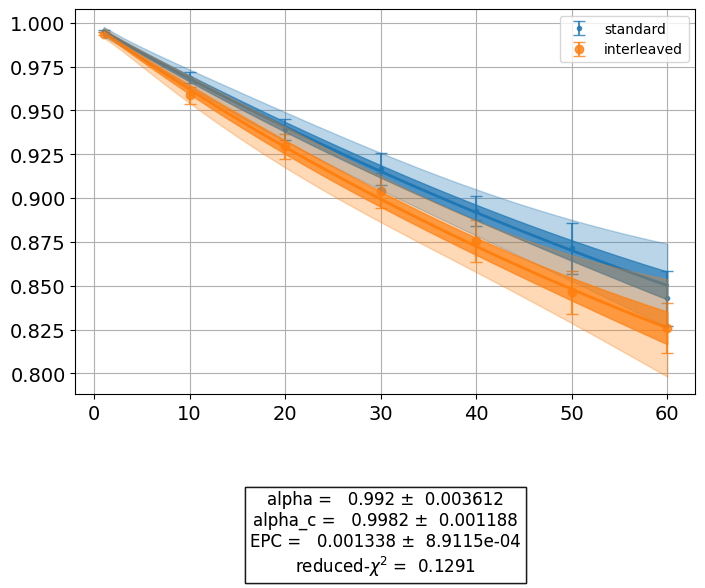

In [14]:
exp_data.figure(0)

The measured fidelity has a relatively large error because we only simulated up to 60 Clifford gates. In experiment it would be better to include 200 to 300 Cliffords. Nevertheless, one can still get a rough estimation of the RB fidelity.